In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# **Preprocessing**

In [2]:
#Input Data
df = pd.read_excel('E:\SEKOLAH\KULIAH\KEGIATAN SEMESTER\Semester 6\Data Mining\Praktikum\Laprak UAS\Bitcoin time series.xlsx')
dfdate = pd.read_csv('E:\SEKOLAH\KULIAH\KEGIATAN SEMESTER\Semester 6\Data Mining\Praktikum\Laprak UAS\BitcoinPrepocessingdate.csv')
#Drop Unnecessary Column
df = df.drop(columns='Unnamed: 0', axis=1)
dfdate = dfdate.drop(columns='Unnamed: 0', axis=1)

In [3]:
df = df[['Price', 'Open', 'High', 'Low', 'Vol.', 'price t-1', 'price t-2', 'price t-3', 'price t-4', 'price t-5', 'low t-1', 'low t-2',  'low t-3',  'low t-4', 'vol t-1', 'vol t-2']]

# **Modelling**

In [4]:
#for splitting validation and training data
from sklearn.model_selection import train_test_split,TimeSeriesSplit, GridSearchCV, cross_val_score
#for identify model
from sklearn.ensemble import RandomForestRegressor
#for Calculate MAE, MSE
from sklearn.metrics import mean_absolute_error,mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, explained_variance_score, make_scorer
import optuna
import time
from pprint import pprint

# **Data Start from 2011**

In [6]:
import datetime

In [7]:
dx = pd.concat([dfdate, df], axis = 1)
dx['Date'] = pd.to_datetime(dx['Date'])
dx = dx[dx['Date']>datetime.datetime(2011, 1, 1)].reset_index(drop=True)

In [8]:
test_size = int(len(dx)*0.3)

a = dx.drop(['Price','Date'], axis = 1)
b = dx['Price']

X_train = a[:-test_size]
y_train = b[:-test_size]
x_test = a[-test_size:]
y_test = b[-test_size:]
print(X_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(2898, 15)
(1241, 15)
(2898,)
(1241,)


In [9]:
rfrg = RandomForestRegressor(random_state=0)
rfrg.fit(X_train, y_train)
rfrg_pred = rfrg.predict(x_test)
mape = mean_absolute_percentage_error(y_test,rfrg_pred)
print('mape = ' , mape)

mape =  0.2381689512831727


<function matplotlib.pyplot.show(close=None, block=None)>

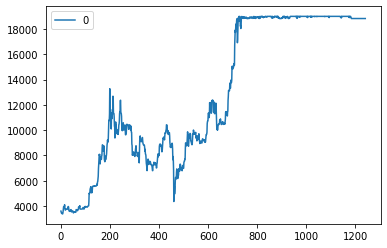

In [10]:
predictiondx = pd.DataFrame(rfrg_pred)
sns.lineplot(data = predictiondx)
plt.show

# **Time Series Split**

In [11]:
arr = np.array(a)
brr = np.array(b)

Tuning

In [12]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 750, stop = 1500, num = 3)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 80, num = 4)]
min_samples_split = [2, 10]
min_samples_leaf = [1, 4]
bootstrap = [True]
para = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rfr = RandomForestRegressor(random_state=0,
                            oob_score=True)
#
tscv = TimeSeriesSplit(n_splits=6, test_size=365)
for train_index, val_index in tscv.split(a):
    train_X, val_X = arr[train_index], arr[val_index]
    train_y, val_y = brr[train_index], brr[val_index]

search = GridSearchCV(estimator=rfr,
                      param_grid=para,
                      scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False),
                      cv=tscv,
                      n_jobs=-1,
                      verbose=2)

search.fit(X_train, y_train)

Fitting 6 folds for each of 96 candidates, totalling 576 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=6, test_size=365),
             estimator=RandomForestRegressor(oob_score=True, random_state=0),
             n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [10, 33, 56, 80],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 4],
                         'min_samples_split': [2, 10],
                         'n_estimators': [750, 1125, 1500]},
             scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False),
             verbose=2)

In [15]:
bestparam = pd.concat([pd.DataFrame(search.cv_results_["rank_test_score"],columns=["Rank"]), pd.DataFrame(search.cv_results_["params"]),pd.DataFrame(search.cv_results_["std_test_score"], columns=["Accuracy"])],axis=1)
bestparam.sort_values(by=['Rank'])

,Rank,bootstrap,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,Accuracy
72,1,True,80,auto,1,2,750,0.216576
24,1,True,33,auto,1,2,750,0.216576
48,1,True,56,auto,1,2,750,0.216576
0,4,True,10,auto,1,2,750,0.216247
25,5,True,33,auto,1,2,1125,0.216768
...,...,...,...,...,...,...,...,...
69,92,True,56,sqrt,4,10,750,0.226063
45,92,True,33,sqrt,4,10,750,0.226063
93,92,True,80,sqrt,4,10,750,0.226063
23,95,True,10,sqrt,4,10,1500,0.226832


Final Model

In [17]:
n_split = []
train_obs = []
test_obs = []
mae_score = []
mape_score = []
pred = []
index = 1
tscv = TimeSeriesSplit(n_splits=11, test_size=365)
for train_index, val_index in tscv.split(a):
    train_X, val_X = arr[train_index], arr[val_index]
    train_y, val_y = brr[train_index], brr[val_index]

    print('enum', index)

    rfr = RandomForestRegressor(n_estimators=750,
                                max_features='auto',
                                min_samples_split=2,
                                min_samples_leaf=1,
                                max_depth=80,
                                bootstrap=True,
                                random_state=0)

    rfr.fit(train_X, train_y)
    y_pred = rfr.predict(val_X)
    mae = mean_absolute_error(val_y, y_pred)
    mape = mean_absolute_percentage_error(val_y, y_pred)*100
    accuracy = 100 - mape
    print('Training Observations: %d' % (len(train_X)))
    print('Testing Observations: %d' % (len(val_y)))
    print(' ')
    print('mape' , mape)
    print('mae' , mae)

    n_split.append(index)
    train_obs.append(len(train_X))
    test_obs.append(len(val_y))
    mae_score.append(mae)
    mape_score.append(mape)
    pred = [y_pred]
    print('-----------------------------')
    index = index + 1


enum 1
Training Observations: 124
Testing Observations: 365
 
mape 42.72299873476826
mae 4.008844931506841
-----------------------------
enum 2
Training Observations: 489
Testing Observations: 365
 
mape 13.858065555329235
mae 12.425630684931507
-----------------------------
enum 3
Training Observations: 854
Testing Observations: 365
 
mape 35.02783130821423
mae 231.67075872146103
-----------------------------
enum 4
Training Observations: 1219
Testing Observations: 365
 
mape 4.785293515432238
mae 15.098199086757893
-----------------------------
enum 5
Training Observations: 1584
Testing Observations: 365
 
mape 1.2489093903938158
mae 4.35938082191795
-----------------------------
enum 6
Training Observations: 1949
Testing Observations: 365
 
mape 2.0619407256286264
mae 19.442252054795006
-----------------------------
enum 7
Training Observations: 2314
Testing Observations: 365
 
mape 68.42443150392793
mae 5486.738856986302
-----------------------------
enum 8
Training Observations: 2

In [20]:
mse = mean_squared_error(val_y, y_pred)
r2 = r2_score(val_y, y_pred)
explain_var_score = explained_variance_score(val_y, y_pred)

In [21]:
print('mape = ' , mape)
print('mae = ' , mae)
print('mse = ' , mse)
print('r2 = ' , r2)
print('varscore = ' , explain_var_score)

mape =  2.500492035709715
mae =  1098.9309150685087
mse =  1975322.0040201526
r2 =  0.9727632485789112
varscore =  0.973929072643718


Visualisasi

In [35]:
predictiondx = pd.DataFrame(y_pred)
testdate = dfdate.iloc[3774:3882, 0].reset_index(drop=True)
testvis = pd.DataFrame(val_y)

In [58]:
datavis = pd.concat([testdate, testvis, predictiondx], keys=['testdate', 'testvis', 'predictiondf'], names= ['Date', 'Actual', 'Pred'], ignore_index=True, axis=1)
datavis = datavis.rename(columns={0: "Date", 1: "Actual", 2:"Pred"})

In [59]:
df_long = datavis.melt('Date', var_name='Cond', value_name='Value')

<function matplotlib.pyplot.show(close=None, block=None)>

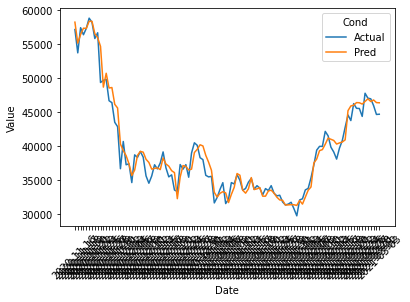

In [67]:
line_plt = sns.lineplot(data = df_long, x='Date', y='Value', hue='Cond')
plt.xticks(rotation=45)
plt.show